In [181]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


/Users/magatigr/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [182]:
plt.rcParams["figure.figsize"] = (6,6)

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns

In [184]:
from tqdm import tqdm
import pathlib

In [185]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score as r2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid

In [186]:
DATA_DIR = pathlib.Path("./")

In [187]:
RS = 283654

### Версии:

- `numpy`: 1.16.3
- `pandas`: 0.24.2
- `sklearn`: 0.21.2

# Загрузка данных

In [188]:
train_target = pd.read_csv(DATA_DIR.joinpath("rubber_target_train.csv"), index_col="date", parse_dates=["date"])
test_target = pd.read_csv(DATA_DIR.joinpath("rubber_test_timestamps.csv"), index_col="date", parse_dates=["date"])
data = pd.read_csv(DATA_DIR.joinpath("rubber_daily.csv"), index_col="date", parse_dates=["date"])

In [189]:
train_target.head()

,rubber
date,
2002-08-01,830.595238
2002-09-01,895.476190
2002-10-01,831.304348
2002-11-01,840.250000
2002-12-01,849.875000


In [190]:
data.head()

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,...,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,41.570,41.570,...,41.50,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,41.515,41.560,...,41.54,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,41.610,41.645,...,41.53,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,41.545,41.620,...,41.50,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,41.645,41.640,...,41.56,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5


In [191]:
test_target.head()

""
date
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01


In [192]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4221 entries, 2002-07-01 to 2019-06-28
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brent_close   4221 non-null   float64
 1   brent_open    4221 non-null   float64
 2   brent_max     4221 non-null   float64
 3   brent_min     4221 non-null   float64
 4   USDCNY_close  4221 non-null   float64
 5   USDCNY_open   4221 non-null   float64
 6   USDCNY_max    4221 non-null   float64
 7   USDCNY_min    4221 non-null   float64
 8   USDTHB_mid    4221 non-null   float64
 9   USDTHB_max    4220 non-null   float64
 10  USDTHB_min    4220 non-null   float64
 11  USDTHB_open   4220 non-null   float64
 12  USDIDR_mid    4219 non-null   float64
 13  USDIDR_max    4092 non-null   float64
 14  USDIDR_min    4092 non-null   float64
 15  USDIDR_open   4091 non-null   float64
 16  USDVND_mid    4209 non-null   float64
 17  USDVND_max    2675 non-null   float64
 18  USDVND_min

Text(0.5, 1, 'Rubber prices')

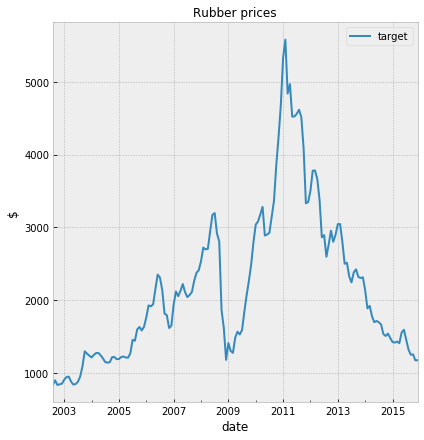

In [193]:
train_target["rubber"].plot(ax=plt.gca(), label="target")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("Rubber prices", fontsize=12)

# Признаки

In [194]:
fts = data.resample("D").mean()

In [195]:
fts

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,USDTHB_max,...,USDTHB_open,USDIDR_mid,USDIDR_max,USDIDR_min,USDIDR_open,USDVND_mid,USDVND_max,USDVND_min,USDVND_open,rubber_close
date,,,,,,,,,,,,,,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770,41.570,41.570,...,41.50,8710.0,8715.0,8669.0,8700.0,15297.5,NaN,NaN,NaN,835.0
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769,41.515,41.560,...,41.54,8805.0,8820.0,8720.0,8720.0,15297.0,NaN,NaN,NaN,827.5
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768,41.610,41.645,...,41.53,8965.0,8985.0,8790.0,8825.0,15297.5,NaN,NaN,NaN,847.5
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767,41.545,41.620,...,41.50,8855.0,8970.0,8790.0,8790.0,15298.5,NaN,NaN,NaN,847.5
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766,41.645,41.640,...,41.56,8860.0,8850.0,8815.0,8830.0,15295.0,NaN,NaN,NaN,847.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-24,64.86,65.50,65.79,64.08,6.8770,6.8736,6.8873,6.8700,30.665,30.820,...,30.81,14140.0,14170.0,14130.0,14130.0,23291.0,23300.0,23280.0,23290.0,1469.0
2019-06-25,65.05,64.89,65.98,64.17,6.8798,6.8715,6.8851,6.8655,30.710,30.750,...,30.66,14125.0,14140.0,14090.0,14135.0,23297.0,23305.0,23284.0,23290.0,1495.0
2019-06-26,66.49,65.80,66.85,65.60,6.8800,6.8876,6.8937,6.8658,30.735,30.870,...,30.76,14175.0,14180.0,14130.0,14130.0,23305.0,23320.0,23287.0,23300.0,1498.0


In [196]:
fts = fts.reset_index()
train_target = train_target.reset_index()

fts["key"] = fts["date"].apply(lambda x: str(x.year) + "_" + str(x.month) if x.month > 9 else str(x.year) + "_0" + str(x.month))
train_target["key"] = train_target["date"].apply(lambda x: str(x.year) + "_" + str(x.month) if x.month > 9 else str(x.year) + "_0" + str(x.month))


fts_grouped = fts.drop("date", axis=1).groupby("key").mean().reset_index()

df = pd.merge(fts_grouped, train_target, how="left", on="key")

__Сдвинем все признаки на 2 месяца вперед, так как мы можем использовать данные не позже 10-го числа предыдущего месяца для прогнозирования значений целевой переменной.__

__Также создадим лаги целевой переменной.__

In [197]:
df.columns

Index(['key', 'brent_close', 'brent_open', 'brent_max', 'brent_min',
       'USDCNY_close', 'USDCNY_open', 'USDCNY_max', 'USDCNY_min', 'USDTHB_mid',
       'USDTHB_max', 'USDTHB_min', 'USDTHB_open', 'USDIDR_mid', 'USDIDR_max',
       'USDIDR_min', 'USDIDR_open', 'USDVND_mid', 'USDVND_max', 'USDVND_min',
       'USDVND_open', 'rubber_close', 'date', 'rubber'],
      dtype='object')

In [198]:
df["rubber_feat"] = df["rubber"].shift(2)

for col in df.columns:
    if col not in ["key", "rubber", "rubber_feat", "date"]:
        df[col] = df[col].shift(2) # сдвигаем на 2 месяца вперед

In [199]:
for col in df.columns:
    if col not in ["key", "rubber", "date"]:
        for lg in range(1, 7):
            df[col+"_lag_"+str(lg)] = df[col].shift(lg)        

In [200]:
df[[col for col in df.columns if "rubber" in col]+["key"]].iloc[:10,:]

,rubber_close,rubber,rubber_feat,rubber_close_lag_1,rubber_close_lag_2,rubber_close_lag_3,rubber_close_lag_4,rubber_close_lag_5,rubber_close_lag_6,rubber_feat_lag_1,rubber_feat_lag_2,rubber_feat_lag_3,rubber_feat_lag_4,rubber_feat_lag_5,rubber_feat_lag_6,key
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002_07
1,NaN,830.595238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002_08
2,812.826087,895.476190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002_09
3,830.000000,831.304348,830.595238,812.826087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002_10
4,895.476190,840.250000,895.476190,830.000000,812.826087,NaN,NaN,NaN,NaN,830.595238,NaN,NaN,NaN,NaN,NaN,2002_11
5,831.304348,849.875000,831.304348,895.476190,830.000000,812.826087,NaN,NaN,NaN,895.476190,830.595238,NaN,NaN,NaN,NaN,2002_12
6,840.250000,903.095238,840.250000,831.304348,895.476190,830.000000,812.826087,NaN,NaN,831.304348,895.476190,830.595238,NaN,NaN,NaN,2003_01
7,848.815789,940.000000,849.875000,840.250000,831.304348,895.476190,830.000000,812.826087,NaN,840.250000,831.304348,895.476190,830.595238,NaN,NaN,2003_02
8,903.095238,945.833333,903.095238,848.815789,840.250000,831.304348,895.476190,830.000000,812.826087,849.875000,840.250000,831.304348,895.476190,830.595238,NaN,2003_03
9,940.000000,877.976190,940.000000,903.095238,848.815789,840.250000,831.304348,895.476190,830.000000,903.095238,849.875000,840.250000,831.304348,895.476190,830.595238,2003_04


In [201]:
df.head(40)

,key,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min,USDTHB_mid,...,rubber_close_lag_3,rubber_close_lag_4,rubber_close_lag_5,rubber_close_lag_6,rubber_feat_lag_1,rubber_feat_lag_2,rubber_feat_lag_3,rubber_feat_lag_4,rubber_feat_lag_5,rubber_feat_lag_6
0,2002_07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002_08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002_09,25.680870,25.663478,25.917826,25.394348,8.276796,8.276796,8.276796,8.276796,41.252609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002_10,26.405500,26.307000,26.672500,26.056000,8.276730,8.276730,8.276730,8.276730,42.145750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002_11,28.290476,28.297619,28.625238,28.000000,8.276986,8.276986,8.276986,8.276986,42.841190,...,NaN,NaN,NaN,NaN,830.595238,NaN,NaN,NaN,NaN,NaN
5,2002_12,27.358261,27.471304,27.710435,27.105217,8.277039,8.277039,8.277039,8.277039,43.649130,...,812.826087,NaN,NaN,NaN,895.476190,830.595238,NaN,NaN,NaN,NaN
6,2003_01,24.226500,24.375500,24.694500,24.018000,8.277085,8.277085,8.277085,8.277085,43.323500,...,830.000000,812.826087,NaN,NaN,831.304348,895.476190,830.595238,NaN,NaN,NaN
7,2003_02,27.585263,27.526842,27.976316,27.210000,8.277489,8.277489,8.277489,8.277489,43.297895,...,895.476190,830.000000,812.826087,NaN,840.250000,831.304348,895.476190,830.595238,NaN,NaN
8,2003_03,30.302857,30.162857,30.628095,29.738095,8.277138,8.277138,8.277138,8.277138,42.751667,...,831.304348,895.476190,830.000000,812.826087,849.875000,840.250000,831.304348,895.476190,830.595238,NaN
9,2003_04,32.269444,32.260556,32.723333,31.844444,8.277672,8.277672,8.277672,8.277672,42.894444,...,840.250000,831.304348,895.476190,830.000000,903.095238,849.875000,840.250000,831.304348,895.476190,830.595238


In [202]:
df["key"] = df["key"].apply(lambda x: int(x))

__Оставим наблюдения с апреля 2003 года (из-за большого кол-ва пропусков из-за лагов)__

In [203]:
df = df[df["key"] >= 200304]

In [204]:
df.isna().sum().sort_values()

key                   0
USDIDR_mid_lag_2      0
USDIDR_mid_lag_1      0
USDTHB_open_lag_6     0
USDTHB_open_lag_5     0
                     ..
USDVND_min_lag_5     71
USDVND_max_lag_5     71
USDVND_open_lag_6    72
USDVND_min_lag_6     72
USDVND_max_lag_6     72
Length: 157, dtype: int64

__Заполним пропуски медианными значениями и отбросим признак с огромным кол-вом пропусков__

In [205]:
df.drop("date", axis=1, inplace=True)

In [206]:
df.drop([col for col in df.columns if "USDVND" in col], axis=1, inplace=True)

df_aux = df[(df["key"] >= 200304) & 
             (df["key"] < 200504)] # на этом периоде посчитаем медиану для заполнения пропусков

for col in df.columns:
    if col != "key" and "rubber_feat" not in col:
        med_to_fill = df_aux[col].median()
        df[col].fillna(med_to_fill, inplace=True)

In [207]:
df_train = df[df["key"] <= 201512] # до декабря 2015 включительно

df_test = df[df["key"] > 201512] # с января 2016

In [208]:
y = df_train["rubber"] # таргет

df_train.drop(["rubber", "key"], axis=1, inplace=True)
df_test.drop(["rubber", "key"], axis=1, inplace=True)

/Users/magatigr/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


__Шкалируем значения признаков.__

In [209]:
minmax = MinMaxScaler(feature_range=(0,1))

df_train_sc = pd.DataFrame(minmax.fit_transform(df_train))
df_test_sc = pd.DataFrame(minmax.fit_transform(df_test))

df_train_sc.columns = df_train.columns
df_test_sc.columns = df_test.columns

In [210]:
all_cols = df_train_sc.columns

best_cols = []

model = LinearRegression()

__Оставим последнюю 21 строку трейна для валидации. В конце анализа мы обучим на первых 132 строках линейную регрессию, градиентный бустинг, случайный лес и бэггинг деревьев и линейных регрессий, а на последней 21 строке (валидационная выборка) сделаем прогнозы, вычислим MAPE и выберем лучшую модель.__

In [211]:
slices = [(0, 60, 72),
         (12, 72, 84),
         (24, 84, 96),
         (36, 96, 108),
         (48, 108, 120),
         (60, 120, 132)]

In [212]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true)) * 100


__Процедура:__
    
__1) Добавляем в модель по 1 признаку из списка all_cols и для каждого признака обучаем модель на разных временных срезах, делаем прогнозы на разных срезах (срезы указаны в списке slices) и вычисляем дял каждого среза out-of-time MAPE.__

__2) Получаем 5 out-of-time MAPE и считаем среднее.__

__3) Получаем словарь, где ключ - добавленный в лин.модель признак, а значение - среднее out-of-time MAPE.__

__4) Выбираем признак, которому соответствует наименьшая out-of-time MAPE, и добавляем в список best_cols.__

__5) Повторяем процедуру до тех пор, пока не отберем 30 признаков.__


In [213]:
dict_mape = {}

for _ in tqdm(range(30)):
    dict_mape_aux = {}
    for feat in all_cols:
        if feat not in best_cols:
            best_cols.append(feat)
            list_mape_aux = []
            for sl in slices:
                i, j, k = sl
                X_train = df_train_sc.iloc[i:j, :]
                X_test = df_train_sc.iloc[j:k, :]
                y_train = y[i:j]
                y_true = y[j:k]
                if len(best_cols) == 1:
                    model.fit(np.array(X_train[best_cols]).reshape(-1,1), y_train)
                    y_pred = model.predict(np.array(X_test[best_cols]).reshape(-1,1))
                else:
                    model.fit(X_train[best_cols], y_train)
                    y_pred = model.predict(X_test[best_cols])
                list_mape_aux.append(mape(y_true, y_pred))
            best_cols.pop()
            dict_mape_aux[feat] = np.mean(list_mape_aux)
    best_col, best_mape = sorted(dict_mape_aux.items(), key=lambda x: x[1])[0]
    best_cols.append(best_col)
    dict_mape[tuple(best_cols)] = best_mape

100%|██████████| 30/30 [01:10<00:00,  2.36s/it]


Text(0, 0.5, 'OOT MAPE')

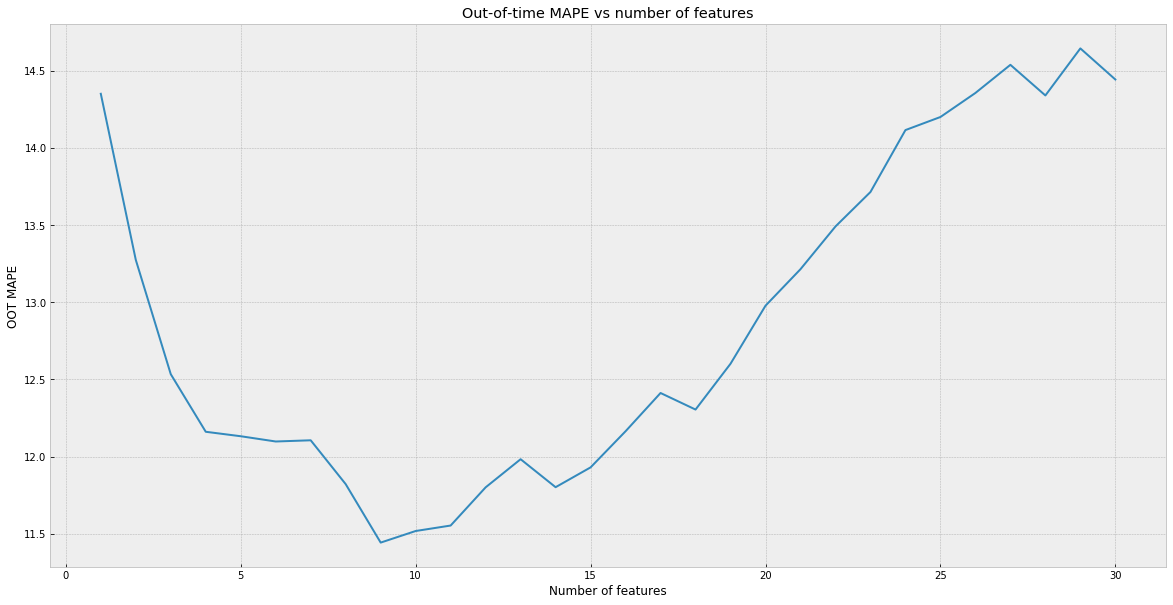

In [214]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(1,31), y=list(dict_mape.values()))
plt.title("Out-of-time MAPE vs number of features")
plt.xlabel("Number of features")
plt.ylabel("OOT MAPE")

__Отберем первые 9 признаков и применим backward stepwise selection, чтобы оставить 5 лучших признаков.__

__В отличие от forward stepwise selection мы будем поочередно отбрасывать признак и считать OOT MAPE и выбирать признак, отбрасывание которого выльется в самый высокий средний OOT MAPE.__

In [215]:
top9_feat = list(list(dict_mape.keys())[8])

model = LinearRegression()

top5_feat = top9_feat.copy()

In [216]:
dict_mape_top5 = {}

for _ in tqdm(range(4)):
    dict_mape_aux = {}
    for feat in top9_feat:
        if feat in top5_feat:
            top5_feat.remove(feat)
            list_mape_aux = []
            for sl in slices:
                i, j, k = sl
                X_train = df_train_sc.iloc[i:j, :]
                X_test = df_train_sc.iloc[j:k, :]
                y_train = y[i:j]
                y_true = y[j:k]
                if len(best_cols) == 1:
                    model.fit(np.array(X_train[top5_feat]).reshape(-1,1), y_train)
                    y_pred = model.predict(np.array(X_test[top5_feat]).reshape(-1,1))
                else:
                    model.fit(X_train[top5_feat], y_train)
                    y_pred = model.predict(X_test[top5_feat])
                list_mape_aux.append(mape(y_true, y_pred))
            top5_feat.append(feat)
            dict_mape_aux[feat] = np.mean(list_mape_aux)
    best_col, best_mape = sorted(dict_mape_aux.items(), key=lambda x: x[1])[0]
    top5_feat.remove(best_col)
    dict_mape_top5[tuple(top5_feat)] = best_mape

100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


__Возьмем отобранные 5 признаков и проанализируем их на мультиколлинеарность.__

__Сделаем это с помощью variance inflation factor (VIF) для каждого признака.__

__Расчёт VIF для i-го признака.__

__1) Обучаем модель, предсказывающую i-ый признак с помощью всех остальных признаков.__

__2) Вычисляем $R^2$ для заданного признака и считаем $VIF_i=1/(1-R^2_i)$.__

__3) Чем выше $VIF_i$, тем выше линейная зависимость признака от остальных признаков.__ 

In [217]:
model = LinearRegression()

X_tr = df_train_sc.iloc[:132,:]

vif_table = pd.DataFrame(columns=['feature', 'vif'], index = range(5))

for num,feat in enumerate(top5_feat):
    ff = top5_feat.copy()
    ff.remove(feat)
    model.fit(X_tr[ff], X_tr[feat])
    vif_table.loc[num, 'feature'] = feat
    vif_table.loc[num, 'vif'] = 1/(1-r2(X_tr[feat], model.predict(X_tr[ff])))

vif_table.sort_values(by="vif")

,feature,vif
1,brent_min_lag_1,3.34546
0,rubber_feat,25.8362
2,rubber_feat_lag_1,30.7937
4,USDIDR_max_lag_6,789.336
3,USDIDR_mid_lag_6,791.858


__Невооруженным взглядом можно заметить высокую мультиколлинеарность.__

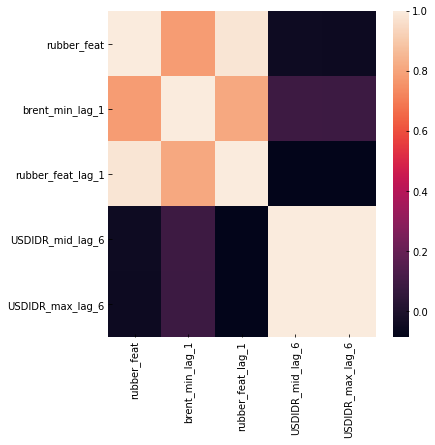

In [218]:
sns.heatmap(X_tr[top5_feat].corr())

In [219]:
final_feat = ["rubber_feat", "USDIDR_max_lag_6"]

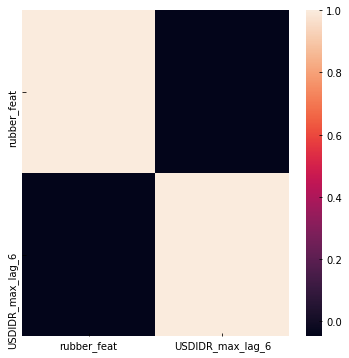

In [220]:
sns.heatmap(X_tr[final_feat].corr())

__Перейдем к выбору лучшей модели.__

In [221]:
# линейная регрессия
model1 = LinearRegression()

# градиентный бустинг
model2 = LGBMRegressor(max_depth=4, n_estimators=300, learning_rate=0.005, random_state=1)
model3 = LGBMRegressor(max_depth=6, n_estimators=300, learning_rate=0.005, random_state=1)

# случайный лес
model4 = RandomForestRegressor(n_estimators=10, random_state=1)
model5 = RandomForestRegressor(n_estimators=15, random_state=1)

# обычный бэггинг линейныйх регрессий
model6 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, random_state=1)
model7 = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=15, random_state=1)

# обычный бэггинг деревьев
model8 = BaggingRegressor(n_estimators=10, random_state=1)
model9 = BaggingRegressor(n_estimators=15, random_state=1)

models = [model1, model2, model3, model4, model5,
         model6, model7, model8, model9]

table_models = pd.DataFrame(columns = ["validation MAPE"], index = ["model "+str(i) for i in range(1,10)])

In [222]:
X_train = df_train_sc[final_feat].iloc[:132,:]
X_test = df_train_sc[final_feat].iloc[132:,:]

y_train = y[:132]
y_test = y[132:]

In [223]:
for num, mod in tqdm(enumerate(models)):
    mod.fit(X_train, y_train)
    mape_valid = mape(y_test, mod.predict(X_test))
    table_models.loc["model "+str(num+1), "validation MAPE"] = mape_valid

9it [00:00, 35.48it/s]


In [224]:
table_models.sort_values(by="validation MAPE")

,validation MAPE
model 4,18.2201
model 8,18.6805
model 9,19.3242
model 5,19.4158
model 2,23.8492
model 3,23.8492
model 1,30.4028
model 6,31.7049
model 7,32.0374


In [225]:
model4.fit(X_train, y_train)
preds_best = model4.predict(X_test)

y_test.index = range(y_test.shape[0])

__Визуализируем прогнозы и реальные значения на валидационной выборке.__

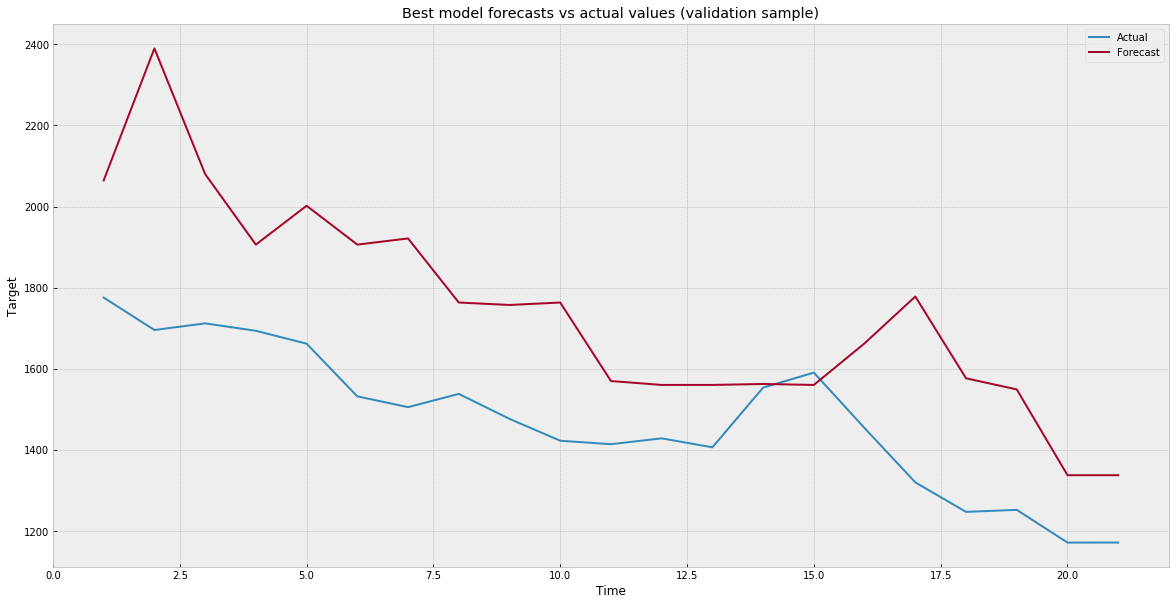

In [226]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(1,22), y=y_test)
sns.lineplot(x=range(1,22), y=preds_best)
plt.title("Best model forecasts vs actual values (validation sample)")
plt.xlabel("Time")
plt.ylabel("Target")
plt.legend(["Actual", "Forecast"])

In [227]:
mape(y_test, preds_best)

18.220057247919147

__Перейдем к предсказаниям на тестовой выборке.__

__На тестовой выборке у нас нет информации о pet_feat (двухмесячный лаг целевой переменной), поэтому будем делать предсказания построчно и по мере увеличения кол-ва предсказаний заполнять столбец rubber_feat в тестовой выборке.__


In [228]:
model4.fit(df_train_sc[final_feat], y)

max_val = df_train["rubber_feat"].max()
min_val = df_train["rubber_feat"].min()

In [229]:
preds_test = []

__Алгоритм:__
    
__1) Делаем предсказание для i-го месяца.__

__2) Добавляем предсказание для i-го месяца в список предсказаний.__

__3) Так как мы используем признак rubber_feat (значение целевой переменной 2 месяца назад), то мы должны обновить значение rubber_feat в тестовой выборке.__

__Для месяца i+2 rubber_feat равняется значению целевой переменной 2 месяца назад, а это означает, что rubber_feat в строке i+2 равно предсказанию rubber_feat для месяца i.__

__Поэтому мы шкалируем предсказание для месяца i и добавляем его в i+2-ую строку столбца rubber_feat тестовой выборки.__


In [230]:
for i in range(df_test_sc.shape[0]):
    pred_to_add = model4.predict(np.array(df_test_sc[final_feat].iloc[i, :]).reshape(1, -1))
    preds_test.append(pred_to_add[0])
    if i+2 <= df_test_sc.shape[0]-1:
        df_test_sc.loc[i+2, "rubber_feat"] = (pred_to_add - min_val) / (max_val - min_val)

In [231]:
preds_test # список предсказаний для тестовой выборки

preds_test_df = pd.DataFrame(columns=["forecast"], index=range(len(preds_test)))

preds_test_df["forecast"] = preds_test

pd.DataFrame(preds_test_df).to_csv("preds_sibur_02.csv")